<a href="https://colab.research.google.com/github/pachterlab/MBP_2023/blob/main/notebooks/atlas_organ_markers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install anndata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import os
from scipy.stats import zscore

def nd(arr):
    return np.asarray(arr).reshape(-1)

In [38]:
# Number of cells per organ
no_cells_per_organ_list = [
    ['ovary', 56095],
    ['lung', 326816],
    ['muscle', 16854],
    ['ileum', 51430],
    ['prostate', 20665],
    ['adipose', 159648],
    ['decidua', 195616],
    ['retina', 2386],
    ['skin', 159912],
    ['kidney', 73895],
    ['tonsil', 2750],
    ['colon', 11226],
    ['mammary', 27741],
    ['bladder', 22632],
    ['yolk_sac', 24260],
    ['rectum', 49122],
    ['brain', 109044],
    ['liver', 382199],
    ['blood', 402560],
    ['bone_marrow', 117926],
    ['stomach', 58205],
    ['thymus', 132527],
    ['lymph_node', 45516],
    ['placenta', 153541],
    ['testis', 180805],
    ['peritoneal', 96566],
    ['eye', 49659]
]

no_cells_per_organ = pd.DataFrame(no_cells_per_organ_list, columns=['organ', 'no_cells'])

organs = np.sort(no_cells_per_organ['organ'])

In [14]:
# Read gene rank matrix
adata = anndata.read_mtx('../files/within_observation_gene_ranks/obs_ranked.mtx.gz')

In [11]:
# Read cell metadata
obs = pd.read_csv('../files/within_observation_gene_ranks/obs_ranked_assignments.txt.gz', sep = '\t',index_col = 0)
obs.index = obs.label

In [13]:
# Read gene metadata
var = pd.read_csv('../files/within_observation_gene_ranks/obs_ranked_genes.txt.gz', sep = '\t', header = None)
var.columns = ['gene_id']

In [15]:
# Annotate matrix
adata.obs = obs
adata.var = var
adata.var.index = var['gene_id']
adata

AnnData object with n_obs × n_vars = 529 × 60623
    obs: 'label'
    var: 'gene_id'

In [33]:
# Read organ marker genes
markers = pd.read_csv('../files//within_observation_gene_ranks/organ_gene_markers.txt', header = None)
markers.columns = ['organ', 'gene_name', 'gene_id']
markers

,organ,gene_name,gene_id
0,adipose,LPL,ENSG00000175445.17
1,bladder,UPK2,ENSG00000110375.3
2,blood,CD3E,ENSG00000198851.9
3,bone_marrow,AHSP,ENSG00000169877.10
4,brain,OLIG2,ENSG00000205927.5
5,colon,CDX2,ENSG00000165556.10
6,kidney,PAX2,ENSG00000075891.21
7,liver,AFP,ENSG00000081051.8
8,lung,SFTPC,ENSG00000168484.12
9,ovary,KLHDC8A,ENSG00000162873.14


## Plot heatmap

In [40]:
# Generate labels with organ name and number of cells
labels = []
for organ in organs:
    nocells = no_cells_per_organ.query('organ == @organ')['no_cells'].values[0]
    labels.append(f'{organ.title().replace("_", " ")} ({nocells:,})')

In [41]:
genes = markers['gene_id'].values
genes = [g.strip() for g in genes]
genes_name = markers['gene_name'].values
genes_name = [g.strip() for g in genes_name]

organs = markers['organ'].values

In [42]:
# Extract data for marker genes
results = []
for organ in organs:
    #gene = fake_genes[0]
    genes_data = []
    for gene, gene_name in zip(markers['gene_id'], markers['gene_name']):
        organ_adata = adata[adata.obs.eval('label == @organ')].copy()
        genes_data.append(np.mean(nd(organ_adata[:,gene].X.todense())))
    results.append(genes_data)

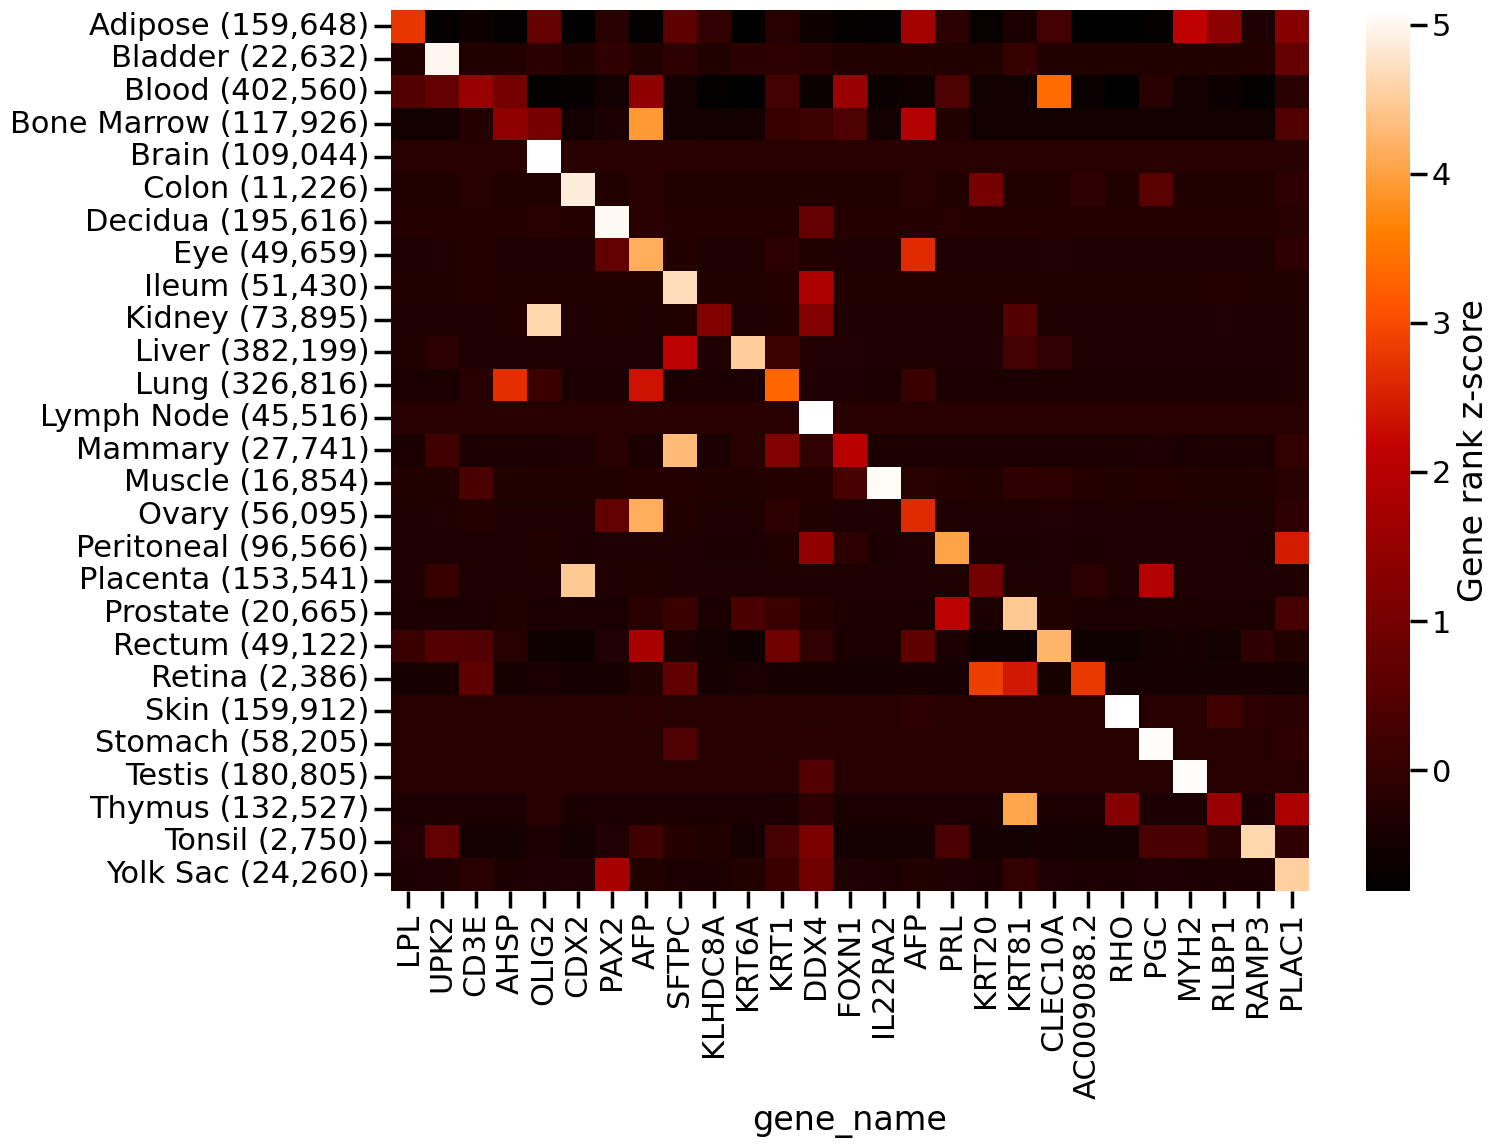

In [43]:
# Plot

sns.set_context('poster')
results_df = pd.DataFrame(zscore(pd.DataFrame(results)))
#results_df =pd.DataFrame(pd.DataFrame(results))


results_df.columns = labels
results_df.index = markers['gene_name']
fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(results_df.T, cmap = "gist_heat", cbar_kws={'label': 'Gene rank z-score'})
fig.tight_layout()

!mkdir -p figures
plt.savefig('figures/fig_1b.png')